Connexion réussie à SQLite
Connexion SQLite est fermée
========== Traitement de la région CVL ==========
Récupération des codes_bss de la région
Connexion réussie à SQLite
Connexion SQLite est fermée
Récupération des 185 chroniques piezzo
Traitement des données


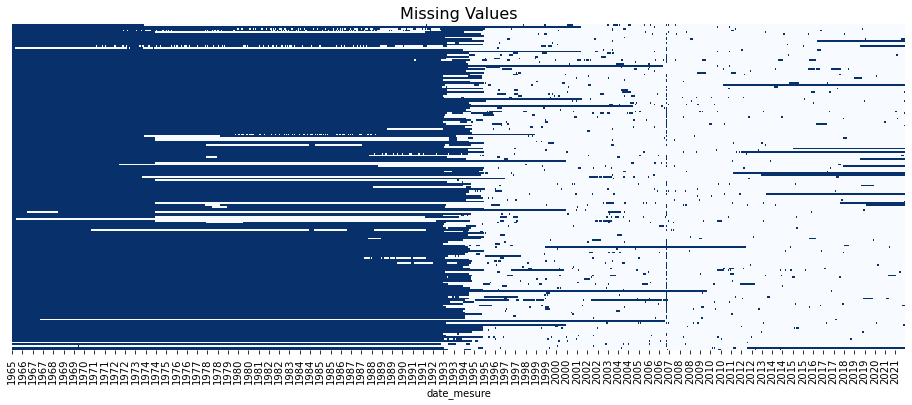

97% des chroniques ont été conservées pour plage de 8 ans.
Date de début : 2001-12-16.
Date de fin : 2013-08-18.


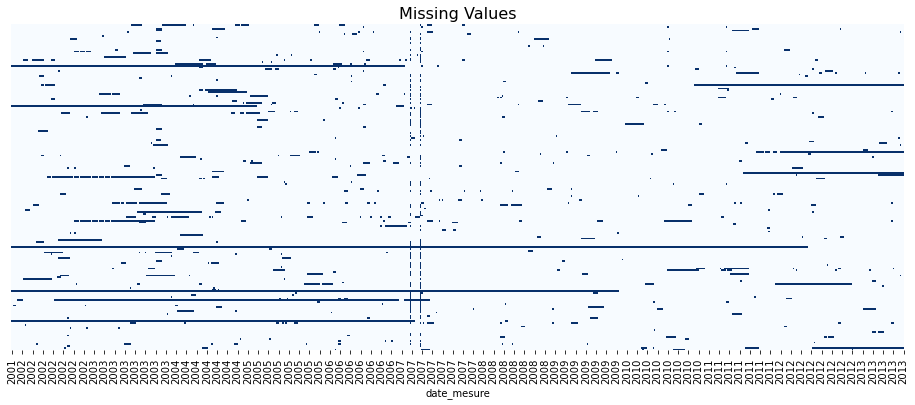

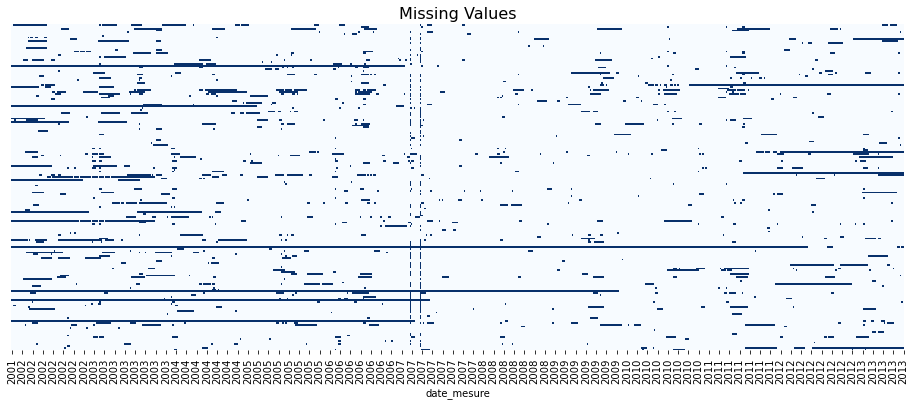

Il reste 117 chroniques avec suffisamment de données.


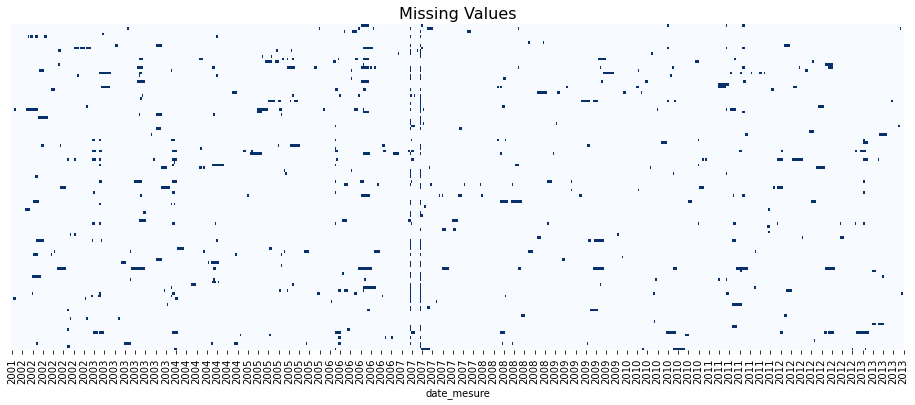

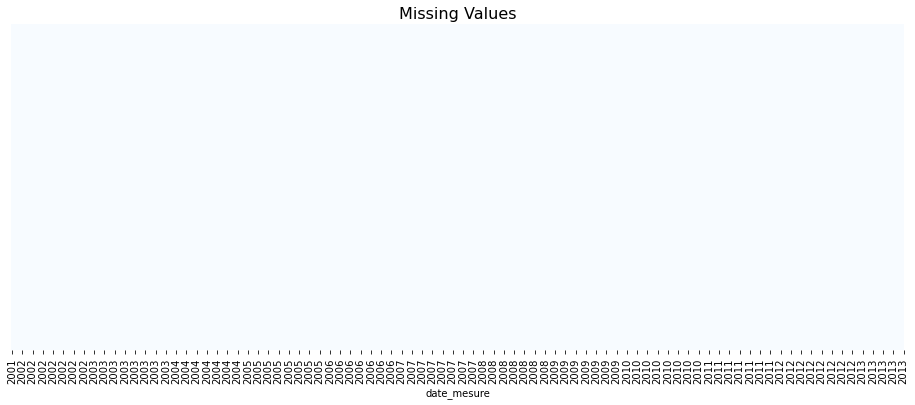

Nombre total de Nan : 0
Il y a 117 chroniques pour le clustering.


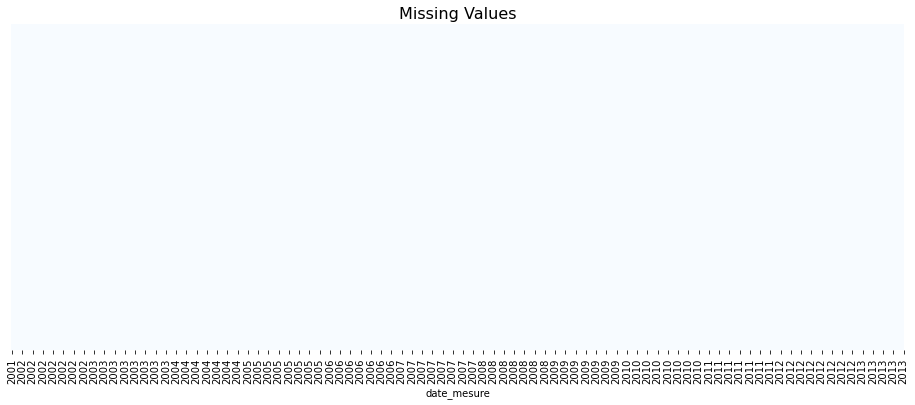

dataframe enregistré en csv.


In [7]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates
import warnings

# Suppression warnings pour calcul np sur des NaN
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

# Liste des fonctions utilisées

# Fonction de requetage auprès de la base de données sqlite
def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()
        

# Fonction pour standardiser les données
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df


#Liste des régions
requete = f"""
        SELECT DISTINCT code_region
        FROM code_region
        INNER JOIN data_piezo
            ON departement = code_dpt
        WHERE fichier_piezo IS 1
         """
resultat = f_requete_sql(requete)

regions = [region[0] for region in resultat]

regions = ["CVL"]

# Traitement pour chaque région
for region in regions :

    print(f"========== Traitement de la région {region} ==========")

    print("Récupération des codes_bss de la région")
    requete = f"""
            SELECT code_bss
            FROM data_piezo
            INNER JOIN code_region
                ON code_dpt = departement
            WHERE code_region IS '{region}'
            AND fichier_piezo IS 1
             """
    data = f_requete_sql(requete)
    code_bss = []
    for code in data:
        code_bss.append(code[0]) 


    print(f"Récupération des {len(code_bss)} chroniques piezzo")
    # Lecture des données du premier piezo de la liste pour initialiser le dataframe
    
    
    directory = '../data/piezo/'
    data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
        
    # ‘epoch’: origin is 1970-01-01
    data = data.resample('W', origin ="epoch").mean()    
    data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)
    # Prise des données depuis 1980

    custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

    for file in code_bss[1:]:
        df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
        df = df.resample('W', origin ="epoch").mean()
        df.rename(columns={"piezo":f"{file}"}, inplace=True)
        data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

    print("Traitement des données")
    f_plot_nan(data)

    # Ajustement des dates de début et de fin
    # La plage de temps minimale est fixée à 8 ans. 
    # La date de début et de fin correspondent à des dates où un maximum de piezos n'ont pas de valeur manquante.
    num_years = 0.0
    pourcentage_NaN = 0.0

    # Minimum de 8 ans d'intervalle
    # Si une date n'est pas calculable, num_years sera égal à NaN et la boucle s'arrête, ce qui n'est pas bon.
    # Comme NaN n'est jamais égal à NaN, la condition d'arrêt n'est pas bonne si num_years n'est égal elle même et possède donc une valeur

    while num_years < 8 or num_years != num_years :
        pourcentage_NaN += 0.01
        date_init = data[(data.isnull().sum(axis=1)/data.shape[1] < pourcentage_NaN) == True].index.min()
        date_fin = data[(data.isnull().sum(axis=1)/data.shape[1] < pourcentage_NaN) == True].index.max()
        num_years = (date_fin - date_init).days / 365.2425

    print(f"{int(100*(1-pourcentage_NaN))}% des chroniques ont été conservées pour plage de 8 ans.")
    print(f"Date de début : {date_init.strftime('%Y-%m-%d')}.")
    print(f"Date de fin : {date_fin.strftime('%Y-%m-%d')}.")

    data_week_from_ = data.loc[date_init:date_fin]

    f_plot_nan(data_week_from_)
    # Suppression des valeurs abérantes
    # Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
    # - Calcul des quartiles et de l'écart interquartile
    # - Suppression des valeurs < Q1 - 1.5*IQR
    # - Suppression des valeurs > Q3 + 1.5*IQR

    data_wo_outliers = data_week_from_.copy()
    for piezo in data_wo_outliers.columns : 
        q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
        q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
        IQR = q3-q1
        data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
        data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN

    f_plot_nan(data_wo_outliers)
    
    # Suppression des piezos avec plus de 10 valeurs manquantes consécutives
    max_consec_nan = 10
    bss_to_drop = []

    for piezo in data_wo_outliers :
        compteur = 0
        for date in data_wo_outliers.index :
            if pd.isnull(data_wo_outliers.loc[date,piezo]):
                compteur += 1
            else : compteur = 0
            if compteur == max_consec_nan:
                bss_to_drop.append(piezo)
                break

    data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)
    print(f"Il reste {data_clean.shape[1]} chroniques avec suffisamment de données.")
    
    f_plot_nan(data_clean)
    
    # Interpolation linéaire pour les données manquantes
    data_interpol = data_clean.copy().interpolate('linear')

    f_plot_nan(data_interpol)
    
    # Réajustement des dates de début et de fin
    debut = []
    fin = []
    for column in data_interpol.columns:
        debut.append(data_interpol[f"{column}"].first_valid_index())
        fin.append(data_interpol[f"{column}"].last_valid_index()) 
    # date_debut = plus grande date en partant du début où il n'y a plus de Nan. Inversement pour date_fin    
    date_debut = max(debut)
    date_fin = min(fin)
    data_interpol = data_interpol.loc[date_debut:date_fin]
    print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")
    print(f"Il y a {data_interpol.shape[1]} chroniques pour le clustering.")

    f_plot_nan(data_interpol)
    
    # Sauvegarde du dataframe traité en format csv en vue du clustering
    data_interpol.to_csv(f"../Clustering/data/{region}.csv", sep = ";")
    print("dataframe enregistré en csv.")

In [6]:
data

,03296X1032_PC1,03646X0086_F1,05471X0070_P1,05445X0081_P1,03627X0052_P1,05475X0057_P1,04915X0009_F1AEP1,05421X0001_FAEP1,04286X0001_FAEP1,04624X0002_FAEP1,...,03252X0011_S,03248X0015_S,05446X0136_S,05465X0001_PZ,04597X0065_PZ,03272X0006_PZ,04894X0016_PZ,03622X0027_PZ,05485X0018_PZ,04866X0038_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1965-10-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-25.730000,NaN,-13.470000,NaN,NaN
1965-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-25.726667,NaN,-13.470000,NaN,NaN
1965-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-25.730000,NaN,-13.485000,NaN,NaN
1965-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-25.792000,NaN,-13.505000,NaN,NaN
1965-11-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-25.790000,NaN,-13.530000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-08,-14.660000,-30.634286,-2.994286,-12.247143,-10.182857,-0.840000,-0.744286,-3.977143,NaN,NaN,...,-3.118571,-3.530000,-7.242857,-5.615714,-5.314286,-25.098571,-11.085714,-12.994286,NaN,-4.531429
2022-05-15,-14.690000,-31.145714,-3.130000,-12.832857,-10.337143,-0.898571,-0.861429,-3.891429,NaN,NaN,...,-4.315714,-3.638571,-7.475714,-5.941429,-6.190000,-25.194286,-11.135714,-13.154286,NaN,-4.612857
2022-05-22,-14.745714,-31.710000,-3.218571,-13.267143,-10.518571,-1.018571,-0.961429,-3.910000,NaN,NaN,...,-4.450000,-3.731429,-7.627143,-6.245714,-6.582857,-25.307143,-11.217143,-13.280000,NaN,-4.692857
